# Traditional ML classification models under wavelet analysis structures
## Introuduction
This file provides my trials of initial investigation of machine learning models.

## Reference

1. The [Nested Cross Validation Understanding Tutorial](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).
2. The [Nested Cross Validation Sklearn Template](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html).

## Implementation

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import sklearn
import scipy 
import argparse
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt

## Implementations
### Configurations

In [2]:
#######################################################################################
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

MEAN_LEFT = 'Mean Left'
MEAN_RIGHT = 'Mean Right'

STD_LEFT = 'STD Left'
STD_RIGHT = 'STD Right'

SKEW_LEFT = 'Skew Left'
SKEW_RIGHT = 'Skew Right'

MAX_LEFT = 'MAX Left'
MAX_RIGHT = 'MAX Right'

MED_LEFT = 'Med Left'
MED_RIGHT = 'Med Right'

VAR_LEFT = 'Var Left'
VAR_RIGHT = 'Var Right'

#######################################################################################
# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'

#######################################################################################
# Configuration for Time-Series Cross Validation.
TRAIN_TEST_SPLIT = LABELS + ' Train and Test'
VALIDATION_SPLIT = LABELS + ' Validation'
TRAIN = 'train'
VALIDATION = 'val'
TEST = 'test'

### Encoder

This part encodes features into numeric values.

In [3]:
# Encoding Lux and Labeling
def encode(df_input):
    luxes = []
    nbacks = []
#     df_numeric_features = df_raw_features.copy()
    df_numeric_features = df_input.copy()

    for index, row in df_numeric_features.iterrows():
        # Label luxes
        if LOWLUX in row[LUX]:
            luxes.append(1)
        elif MIDLUX in row[LUX]:
            luxes.append(2)
        elif HIGHLUX in row[LUX]:
            luxes.append(3)

        # Label task difficulties
        if NOBACK in row[LABELS]:
            nbacks.append(0)
        elif ONEBACK in row[LABELS]:
            nbacks.append(1)
        elif TWOBACK in row[LABELS]:
            nbacks.append(2)
        elif THREEBACK in row[LABELS]:
            nbacks.append(3)

    df_numeric_features[LUX] = luxes
    df_numeric_features[LABELS] = nbacks
    
    # Output the results
    df_output = df_numeric_features.copy()
    return df_output

### Data Preprocessing

In [4]:
# <TODO> Add data processing - Mainly the data normalization and standardization.

### Data visualization

In [5]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

### Auxiliary Functions

In [6]:
# Show machine learning models' performance.
def show_performance(y_true, y_pred, model_name):
    # Get the accuracy score.
    acc_score = accuracy_score(y_true, y_pred)
    
    # Get the F1 score.
    # I chose the macro for worrying about the imbanlance of labels. In my case, since I don't filter instances bsed on blinking rates, I use micro.
    # Ref: https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult. The 'micro' uses the global number of TP, FN, FP and calculates the F1 directly without favouring any classes.
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')  # Before resetting the 0-back time equals to the 1,2,3-backs, I use the macro.
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    # Plot the confusion matrix.
    ax = plt.figure().subplots()
    ax.set(title=model_name + " MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    return acc_score, f1_score

In [7]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

#### Clean the Instances and Features

Cross validation methods [[Ref](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)]: 

1. Forward Chaining / Last Block Evaluation.
2. hv cross validation.

In [8]:
# Split the traing and testing dataset. Select validated rows/instances by thresholdings.
def split_dataset(args, df_input):
    df = df_input.copy()
    
#     # Plot the original class distributions.
#     plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= args.blinking_rate_threshold]
    df = df.loc[df[ISBLINK_RIGHT] <= args.blinking_rate_threshold]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(args.blinking_rate_threshold) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # I use the hv cross validation method because the raw data was time-series dataset and adjacent data points are highly dependant.
    if args.split_mode == 'Inclusive':  # It could be a magical string here because the choices are limited in the arg_parser.
        # Initialization.
        list_dfs_output_trains_4_val = []
        list_dfs_output_vals = []
        
        # Traverse the dataframe's columns.
        # Get the train and test datasets.
        df_output_train_4_test = df.loc[df[TRAIN_TEST_SPLIT] == TRAIN]
        df_output_test = df.loc[df[TRAIN_TEST_SPLIT] == TEST]
        
        # Get the trainings and validations in validation sets.
        val_cols = df.filter(like=VALIDATION_SPLIT).columns
        for col in val_cols:
            df_train_4_val = df.loc[df[col] == TRAIN]
            df_val = df.loc[df[col] == TEST]
            list_dfs_output_trains_4_val.append(df_train_4_val)
            list_dfs_output_vals.append(df_val)
        # The time series dataset split ends here.
    
    elif args.split_mode == 'Exclusive':
        pass  # <TODO: test strangers that never appeared in the training dataset later when the dataset is big enough.>
    
#     # Reset the index.
#     df = df.reset_index()
#     df = df.loc[:, df.columns != 'index']
    
    # Get the output.
    # Already got them in the if-else structure.
    return df_output_train_4_test, df_output_test, list_dfs_output_trains_4_val, list_dfs_output_vals

In [9]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Remove all the labels for spliting dataset first.
    # The train and test split labels.
    df = df.loc[:, df.columns != TRAIN_TEST_SPLIT]
    # The validation's train and validation labels.
    val_cols = df.filter(like=VALIDATION_SPLIT).columns
    for col in val_cols:
        df = df.loc[:, df.columns != col]
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
#         selected_feature_sets.append(ISBLINK_LEFT)
#         selected_feature_sets.append(ISBLINK_RIGHT)
#         selected_feature_sets.append(LUX)
        
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets] 
        
        # Remove appended features.
        selected_feature_sets.remove(LABELS)
#         selected_feature_sets.remove(ISBLINK_LEFT)
#         selected_feature_sets.remove(ISBLINK_RIGHT)
#         selected_feature_sets.remove(LUX)
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

#### Train, validate, and Predict (Test) Models

In [10]:
# Train, validate and predict(test) the models. Maybe needs to separate these parts.
def run_baseline_models(args, df_input_train_4_test, df_input_test, list_dfs_input_trains_4_val, list_dfs_input_vals, label_string): # <TODO> need to modify later.
    # Split dataset.
    def _get_X_y(df):
        X = df.loc[:, df.columns != LABELS].to_numpy()
        y = df.loc[:, df.columns == LABELS].to_numpy()
        y = np.reshape(y, -1)
        return X, y
    
    # Get X and y for train and test.
    X_train, y_train = _get_X_y(df=df_input_train_4_test)
    X_test, y_test = _get_X_y(df=df_input_test)
    
    # <TODO> Get the Xs and ys for train in validation and validation datasets.
    # Play with list_dfs_input_trains_4_val, list_dfs_input_vals.
    
    # Train models. <TODO: use the validations>
    print('------------------------------------------------' + label_string + ' Model ------------------------------------------------')
    
#     # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
#     clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
#     # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
#     clf_svm.fit(X_train, y_train)
#     y_pred_svm = clf_svm.predict(X_test)
#     score_svm = show_performance(y_true=y_test, y_pred=y_pred_svm, model_name = SVM)
#     acc_score_svm = 0
    
    # KNN model.
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    # Train the model.
    clf_knn.fit(X_train, y_train)
    # Test.
    y_pred_knn = clf_knn.predict(X_test)
    acc_score_knn, f1_score_knn = show_performance(y_true=y_test, y_pred=y_pred_knn, model_name = KNN)
    
    # Random Forest model.
    clf_rf = RandomForestClassifier(max_depth=args.rf_depth, random_state=999)
    # Train the model.
    clf_rf.fit(X_train, y_train)
    # Test.
    y_pred_rf = clf_rf.predict(X_test)
    acc_score_rf, f1_score_rf = show_performance(y_true=y_test, y_pred=y_pred_rf, model_name = RF)
    
    # Print the results.
    print('\nThe KNN accuracy is: ' + str(acc_score_knn) +  '\nThe RF accuracy is: ' + str(acc_score_rf))
    print('\nThe KNN F1 is: ' + str(f1_score_knn) +  '\nThe RF F1 is: ' + str(f1_score_rf))
    print('\nThe used features are: ') # Briefly display the features utilized.

    # Output the data.
    return

#### Machine Learning Pipeline

In [11]:
# The pipeline for experiments.
def run(args):
    # Read in data from the csv file.
    filepath = args.path
    df_raw_features = pd.read_csv(filepath)
    
    # Encode features into numeric values.
    df_numeric_features = encode(df_input=df_raw_features)

    # Get validated instances.
    df_train_4_test, df_test, list_dfs_trains_4_val, list_dfs_vals = split_dataset(args=args, df_input=df_numeric_features)

    # Compare different feature sets. <TODO: the function input> <TODO: try feature selection when necessary.>
    # Time-domain baseline feature sets.
    time_domain_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT]
    df_baseline_time_features_train = select_features(df_input=df_train_4_test, 
                                                      selected_feature_sets=time_domain_features, 
                                                      dropped_feature_sets=False)
    df_baseline_time_features_test = select_features(df_input=df_test, 
                                                     selected_feature_sets=time_domain_features, 
                                                     dropped_feature_sets=False)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_baseline_time_features_train, 
                        df_input_test=df_baseline_time_features_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='Time-domain-based Features')

    # # Freqeuncy baseline feature sets.
    # freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]

    # freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
    
    # # Only wavelet coefficients features.
    # dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    # df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)

    # IPA LHIPA and AVE_DM + DF_DM features.
    freq_time_baseline_features = [AVE_DM, DIFF_DM, MEAN_LEFT, MEAN_RIGHT, VAR_LEFT, VAR_RIGHT, STD_LEFT, STD_RIGHT, MAX_LEFT, MAX_RIGHT, SKEW_LEFT, SKEW_RIGHT, MED_LEFT, MED_RIGHT,IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    df_baselines_train = select_features(df_input=df_train_4_test, 
                                         selected_feature_sets=freq_time_baseline_features, 
                                         dropped_feature_sets=False)
    df_baselines_test = select_features(df_input=df_test, 
                                        selected_feature_sets=freq_time_baseline_features, 
                                        dropped_feature_sets=False)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_baselines_train, 
                        df_input_test=df_baselines_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='All Time and Frequency Domain Baseline Features')


    # My proposed feature based features.
    dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
    df_proposed_train = select_features(df_input=df_train_4_test, 
                                        selected_feature_sets=False, 
                                        dropped_feature_sets=dropped_IPA_LHIPA_features)
    df_proposed_test = select_features(df_input=df_test, 
                                       selected_feature_sets=False, 
                                       dropped_feature_sets=dropped_IPA_LHIPA_features)
    run_baseline_models(args=args, 
                        df_input_train_4_test=df_proposed_train, 
                        df_input_test=df_proposed_test, 
                        list_dfs_input_trains_4_val=list_dfs_trains_4_val, 
                        list_dfs_input_vals=list_dfs_vals, 
                        label_string='My Proposed Features')


    # # All features baseline.
    # df_all_baseline = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=False)

    return

## Implementation - My Console

In [12]:
# Allocate arguments.
# Ref: https://docs.python.org/3/library/argparse.html; How to use ref: https://www.folkstalk.com/2022/09/argparse-choices-with-code-examples.html.
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-f')
    parser.add_argument("--path", type=str, default='../Data/Results/28-11-18-38/results.csv', 
                        help="The path to read processed features.")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--argument_save_path', type=str, default='../Data/Results/',  # TODO: add the results output stream.
#                         help='The path to save arguments.')
#     parser.add_argument('--results_save_path', type=str, default='../Data/Results/',
#                     help='The path to save processed data and generated features.')
#     parser.add_argument('--results_csv_filename', type=str, default='results.csv',
#                     help='The result csv filename.')
    parser.add_argument('--split_mode', type=str, default='Inclusive',
                        choices=['Inclusive', 'Exclusive'],
                        help='Whether or not include one individual in both train and test dataset. Inclusive for including, Exclusive for not including.')
    parser.add_argument('--blinking_rate_threshold', type=float, default=1.00,
                        help='The threshold of filtering invalid data with low blinking rates.')
    parser.add_argument('--rf_depth', type=int, default=10,
                        help='The max depth of the random forest model.')
    return parser.parse_args(args = [])

The blinking threshold is: 1.0. Before there was: 8802 instances, then there is : 8802 instances. 0 instances are lost.


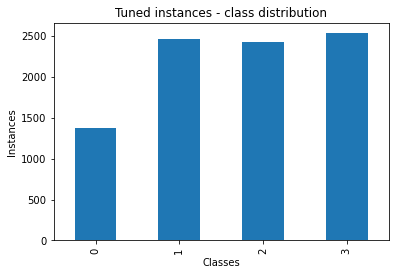

------------------------------------------------Time-domain-based Features Model ------------------------------------------------


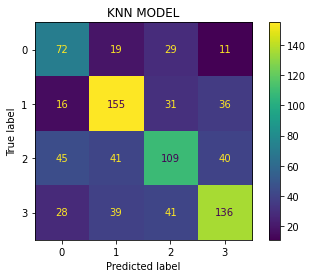

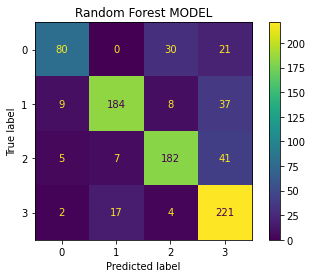


The KNN accuracy is: 0.5566037735849056
The RF accuracy is: 0.7865566037735849

The KNN F1 is: 0.5488901849210793
The RF F1 is: 0.7766685470759476

The used features are: 
------------------------------------------------All Time and Frequency Domain Baseline Features Model ------------------------------------------------


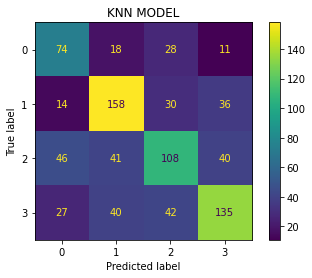

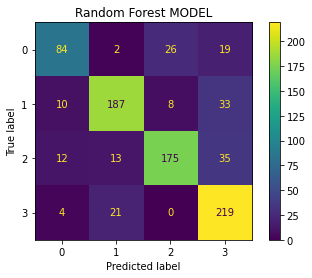


The KNN accuracy is: 0.5601415094339622
The RF accuracy is: 0.7841981132075472

The KNN F1 is: 0.553054236299025
The RF F1 is: 0.7732567967001951

The used features are: 
------------------------------------------------My Proposed Features Model ------------------------------------------------


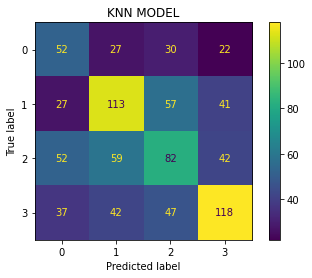

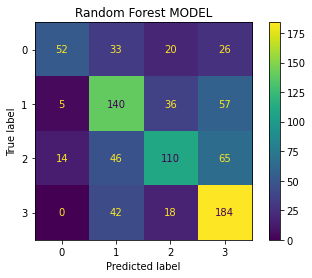


The KNN accuracy is: 0.43042452830188677
The RF accuracy is: 0.5731132075471698

The KNN F1 is: 0.42215801339388614
The RF F1 is: 0.5599805710993758

The used features are: 


In [13]:
# Implement.
# Get arguments.
args = parse_args()
# Run the pipeline
run(args=args)

In [14]:
# Read data and make them into processable formalities.
# filepath = '../Data/Results/21-11-13-13/results.csv' # Without ipa and lhipa features.
# filepath = '../Data/Results/22-11-22-23/results.csv' # With ipa and lhipa features. Sliding window: 5:3.
# filepath = '../Data/Results/23-11-09-08/results.csv' # With ipa and lhipa features. Sliding window: 5:4.
# filepath = '../Data/Results/23-11-09-51/results.csv' # With ipa and lhipa features. Sliding window: 2:1.6
# filepath = '../Data/Results/23-11-12-48/results.csv' # With ipa and lhipa features. Sliding window: 8-7
# filepath = '../Data/Results/23-11-14-06/results.csv' # With ipa and lhipa features. Sliding window: 10-8 
# filepath = '../Data/Results/23-11-14-24/results.csv' # With ipa and lhipa features. Sliding window: 10-9.5 --> # The longer the window, the more data, the better.
# filepath = '../Data/Results/23-11-15-59/results.csv' # Inclueded the PD statistical features. The best. Sliding window: 5-4.5 --> 0.98 --> Without lux, blinking rates, the pure time baseline and baseline + IPA, LHIPA would be still be great: 0.94; 0.96
# filepath = '../Data/Results/23-11-16-17/results.csv'# Inclueded the PD statistical features. Sliding window: 10-9.5 --> 0.988;0.989
# filepath = '../Data/Results/23-11-16-24/results.csv'# Inclueded the PD statistical features. Sliding window: 4-3.5 --> 0.92;0.88
# filepath = '../Data/Results/23-11-16-55/results.csv'# Inclueded the PD statistical features. Sliding window: 4-3 --> 0.96;0.96
# filepath = '../Data/Results/23-11-16-36/results.csv'# Inclueded the PD statistical features. Sliding window: 5-4 --> 0.94;0.95
# filepath = '../Data/Results/23-11-16-43/results.csv'# Inclueded the PD statistical features. Sliding window: 5-2.5 --> 0.88;0.89

# filepath = '../Data/Results/23-11-18-07/results.csv'# Inclueded the PD statistical features. All participants, include RZ(04) and ZL (05). Sliding window: 4-3 -->